<a href="https://colab.research.google.com/github/Pierre-Alexandre01/Asian-Option-Pricing-/blob/main/PROJET_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance --quiet

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

msft = pd.read_csv("/content/drive/MyDrive/HSG PA /MSFT_2020_2025 .csv")[1:]


msft = msft.dropna().reset_index(drop=True).drop('Price', axis = 1)


for col in msft.columns:
    if col != 'Date':
        msft[col] = msft[col].astype(float)


In [6]:
msft.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [7]:
msft['returns'] = np.log(msft['Close'] / msft['Close'].shift(1))
msft = msft.dropna().reset_index(drop = True)
msft.head()

,Close,High,Low,Open,Volume,returns
0,169.832199,170.071494,164.519869,165.802485,51286600.0,0.043896
1,171.535995,172.675026,168.683593,172.292160,53875900.0,0.009982
2,167.094711,170.990421,166.558679,168.272037,39370500.0,-0.026232
3,171.181854,171.335006,166.357679,167.018135,30372900.0,0.024166
4,173.019608,175.785853,172.196433,172.885603,36839200.0,0.010678


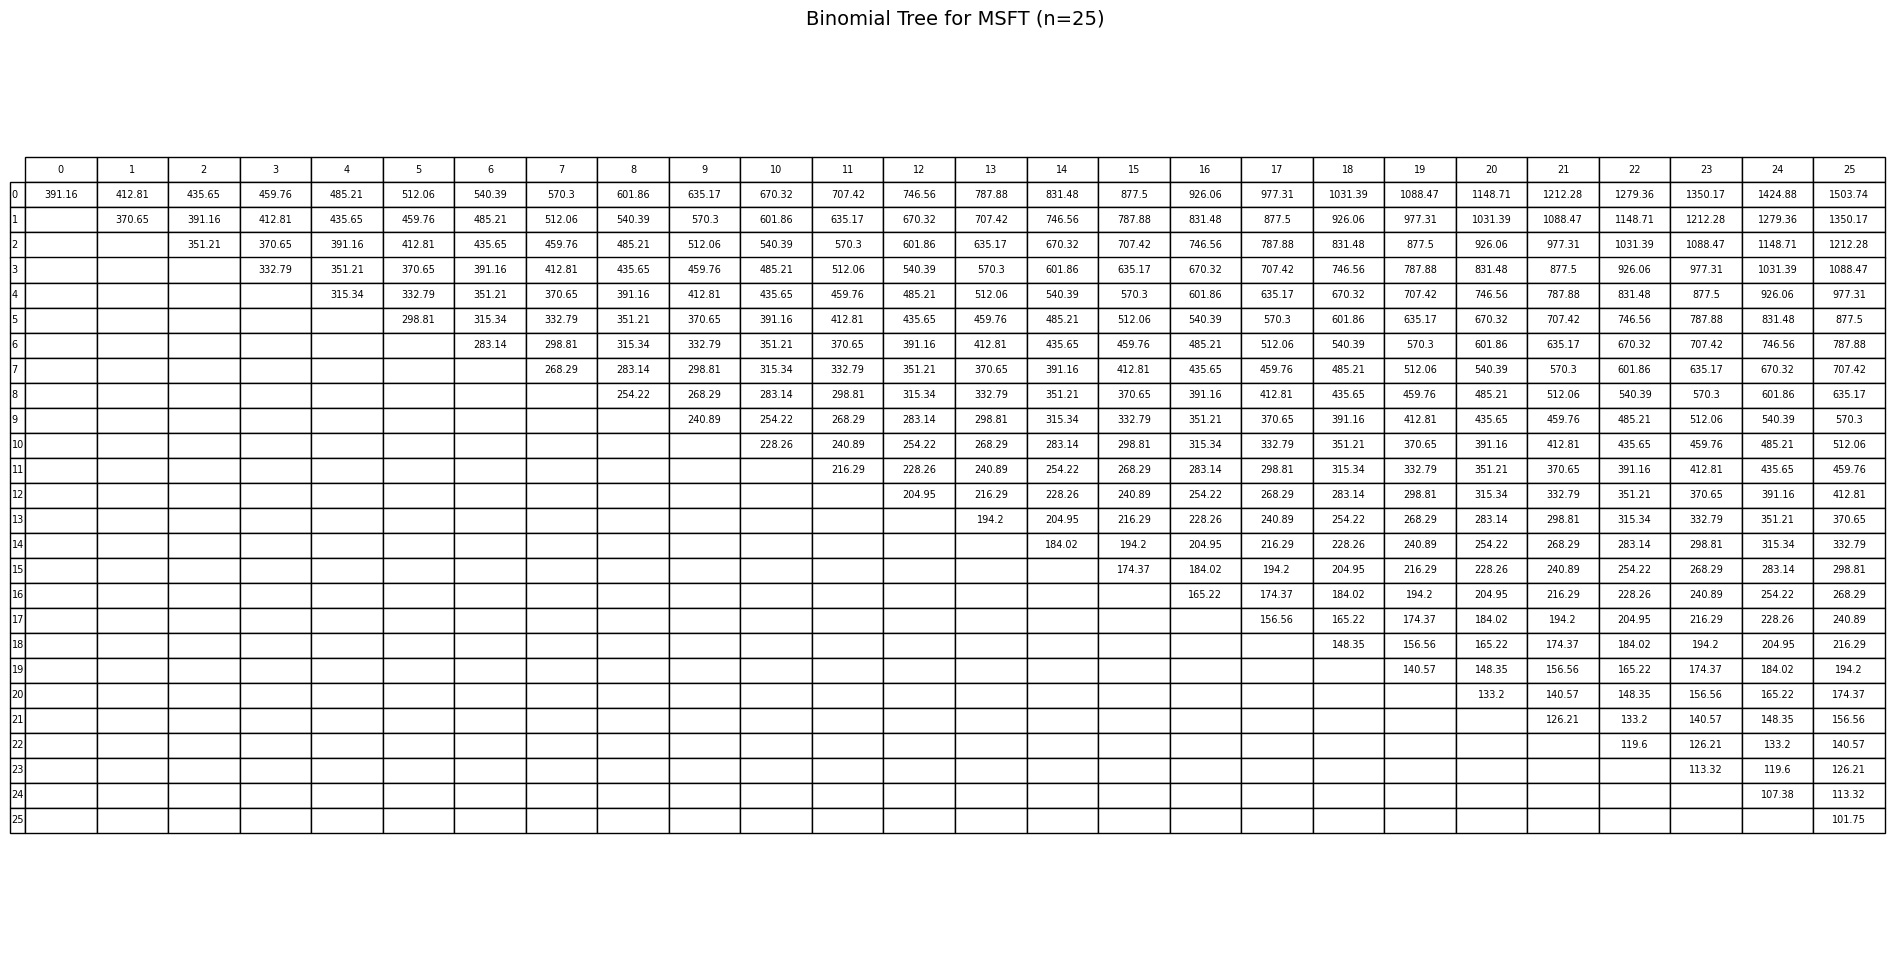

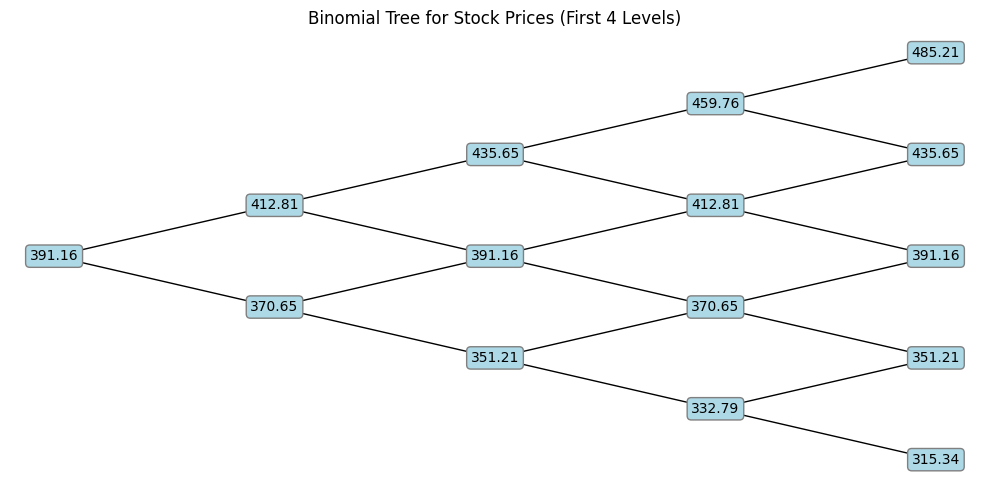

In [8]:
n = 25
T = 1
r = 0.01
S0 = msft['Close'].values[-1]
delta_t = T / n

sigma_daily = msft['returns'].std()
sigma_annualized = sigma_daily * np.sqrt(250)

u = np.exp(sigma_annualized * np.sqrt(delta_t))
d = np.exp(-sigma_annualized * np.sqrt(delta_t))
K = S0
discount = np.exp(-r * delta_t)

#(a)
stock_tree = np.zeros((n + 1, n + 1))
for i in range(n + 1):
    for j in range(i + 1):
        stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

stock_tree_df = pd.DataFrame(stock_tree).replace(0, np.nan).round(2)
stock_tree_df


fig, ax = plt.subplots(figsize=(24, 12))

text_matrix = stock_tree_df.fillna("").astype(str).values

table = ax.table(
    cellText=text_matrix,
    rowLabels=stock_tree_df.index,
    colLabels=stock_tree_df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(1.0, 1.5)

ax.axis('off')
plt.title("Binomial Tree for MSFT (n=25)", fontsize=14)

plt.savefig("binomial_tree_matrix_readable.png", bbox_inches='tight', dpi=300)
plt.show()

def plot_binomial_tree_visual(stock_tree_df, levels=4):
    fig, ax = plt.subplots(figsize=(10, 5))
    positions = {}

    for i in range(levels + 1):
        for j in range(i + 1):
            price = stock_tree_df.iloc[j, i]
            if not np.isnan(price):
                x = i
                y = -j + i / 2
                positions[(j, i)] = (x, y)
                ax.text(x, y, f'{price:.2f}', ha='center', va='center',
                        bbox=dict(boxstyle="round", facecolor="lightblue", edgecolor="gray"))

    for i in range(levels):
        for j in range(i + 1):
            if (j, i) in positions:
                x, y = positions[(j, i)]
                if (j, i + 1) in positions:
                    xu, yu = positions[(j, i + 1)]
                    ax.plot([x, xu], [y, yu], 'k-', lw=1)
                if (j + 1, i + 1) in positions:
                    xd, yd = positions[(j + 1, i + 1)]
                    ax.plot([x, xd], [y, yd], 'k-', lw=1)

    ax.set_title("Binomial Tree for Stock Prices (First 4 Levels)")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_binomial_tree_visual(stock_tree_df, levels=4)







In [14]:
#(b)(c)

n = 25
T = 1
r = 0.01
S0 = msft['Close'].values[-1]
delta_t = T / n

sigma_daily = msft['returns'].std()
sigma_annualized = sigma_daily * np.sqrt(250)

u = np.exp(sigma_annualized * np.sqrt(delta_t))
d = np.exp(-sigma_annualized * np.sqrt(delta_t))
K = S0


payoffs = []
prices = []
weighted_payoffs = []
q = (1 + r * delta_t - d) / (u - d)


for i in tqdm(range(0, 2**n)):
    path = [(i >> j) & 1 for j in range(n - 1, -1, -1)]

    multipliers = np.where(np.array(path) == 0, u, d)
    num_ups = np.sum(np.array(path) == 0)
    num_downs = len(path) - num_ups

    path_probability = (q ** num_ups) * ((1 - q) ** num_downs)

    price = S0 * np.cumprod(multipliers)
    M = np.mean(price)
    prices.append(M)
    payoffs.append(max(M - K, 0))
    weighted_payoffs.append(max(M - K, 0) * path_probability)

100%|██████████| 33554432/33554432 [23:34<00:00, 23723.16it/s]


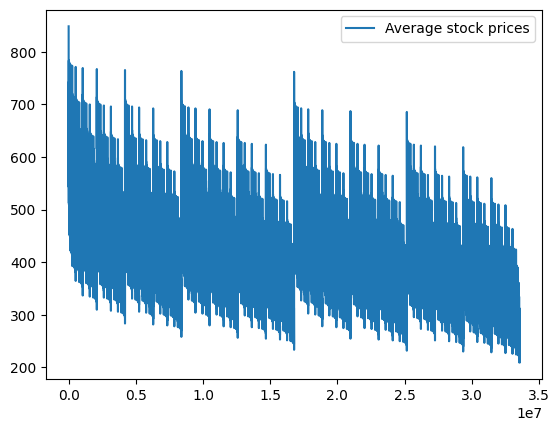

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(prices, label = 'Average stock prices')
plt.legend()
plt.show()

In [16]:
#(d) Risk-neutral probability

q = (1 + r * delta_t - d) / (u - d)
print(f"Risk-neutral probability q = {q:.4f}")

Risk-neutral probability q = 0.4902


In [17]:
#(e) Option Price

option_price = np.exp(-r * T) * np.sum(weighted_payoffs)
print(f"Asian option price at t = 0: {option_price:.4f}")

Asian option price at t = 0: 25.9510


In [18]:
num_simulations = 100_000

r_values = [0.005, 0.01, 0.02, 0.03]
sigma_values = [0.15, 0.20, 0.25, 0.30, 0.35]

results = []


for r, sigma in tqdm(product(r_values, sigma_values), total=len(r_values)*len(sigma_values), desc="Monte Carlo Robustness Check"):

    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    q = (1 + r * delta_t - d) / (u - d)

    payoffs = []

    for _ in range(num_simulations):

        path = np.random.choice([0, 1], size=n, p=[q, 1 - q])
        multipliers = np.where(path == 0, u, d)
        price_path = S0 * np.cumprod(multipliers)
        average_price = np.mean(price_path)
        payoff = max(average_price - K, 0)
        payoffs.append(payoff)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    results.append((r, sigma, option_price))
    print(f"r = {r:.3f}, sigma = {sigma:.2f} → Monte Carlo Price = {option_price:.4f}")


df_results_mc = pd.DataFrame(results, columns=["r", "sigma", "option_price"])
pivot_mc = df_results_mc.pivot(index="sigma", columns="r", values="option_price")
print(pivot_mc.round(4))

NameError: name 'product' is not defined

In [19]:
from scipy.stats import norm
import numpy as np

r = 0.01
sigma_annualized = sigma_daily * np.sqrt(250)
delta_t = T / n
u = np.exp(sigma_annualized * np.sqrt(delta_t))
d = np.exp(-sigma_annualized * np.sqrt(delta_t))
q = (1 + r * delta_t - d) / (u - d)
K = S0
path_probs = []

for i in range(2**n):
    path = [(i >> j) & 1 for j in range(n - 1, -1, -1)]
    num_ups = sum(bit == 0 for bit in path)
    num_downs = n - num_ups
    prob = (q ** num_ups) * ((1 - q) ** num_downs)
    path_probs.append(prob)


prices_np = np.array(prices)
path_probs_np = np.array(path_probs)


path_probs_np /= path_probs_np.sum()


mu = np.sum(prices_np * path_probs_np)
var = np.sum(path_probs_np * (prices_np - mu) ** 2)
std = np.sqrt(var)

d = (mu - K) / std
option_price_normal = np.exp(-r * T) * ((mu - K) * norm.cdf(d) + std * norm.pdf(d))

print(f"Asian option price (normal approximation using true averages): {option_price_normal:.4f}")

Asian option price (normal approximation using true averages): 26.1359


In [20]:
import numpy as np
from scipy.stats import norm

# Parameters
n = 25
T = 1
r = 0.01
S0 = msft['Close'].values[-1]
K = S0
delta_t = T / n

# Volatility
sigma_daily = msft['returns'].std()
sigma_annualized = sigma_daily * np.sqrt(250)

# Binomial setup
u = np.exp(sigma_annualized * np.sqrt(delta_t))
d = np.exp(-sigma_annualized * np.sqrt(delta_t))
q = (1 + r * delta_t - d) / (u - d)

# Approximate number of up moves X ~ B(n, q) by N(np, npq)
mean_up = n * q
std_up = np.sqrt(n * q * (1 - q))

# Define a range of up moves to evaluate
up_range = np.linspace(0, n, 1000)

# Approximate probability density function of number of up moves
pdf = norm.pdf(up_range, loc=mean_up, scale=std_up)

# For each number of up moves, estimate final stock price and average along the path
# Crude estimate: average price ≈ (S0 + S_T) / 2
final_prices = S0 * (u ** up_range) * (d ** (n - up_range))
avg_prices = (S0 + final_prices) / 2
payoffs = np.maximum(avg_prices - K, 0)

# Approximate integral under normal
delta_x = up_range[1] - up_range[0]
option_price = np.exp(-r * T) * np.sum(payoffs * pdf * delta_x)

print(f"Asian option price via normal approximation from binomial CLT: {option_price:.4f}")

Asian option price via normal approximation from binomial CLT: 21.8283
